Práctica Calificada -  Casual ML

Grupo:
- Serghi Arista
- Paola Cordova
- Milagros Meza
- Mayra Gavilan

1. Merge de ambas bases de datos basado en la variable user_id

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Paso 1: Importar las bibliotecas necesarias
import pandas as pd
import numpy as np

# Paso 2: Cargar los archivos CSV
countries_df = pd.read_csv('countries.csv')
ab_data_df = pd.read_csv('ab_data.csv')

# Paso 3: Realizar el merge de los DataFrames en base a "user_id"
data = pd.merge(ab_data_df, countries_df, on='user_id', how='inner')

data.head(5)

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


2. Nos quedamos con aquellas observaciones cuya asignacion fue perfecta.  Aquellos que pertenecen al grupo de los tratados deben haber visto la pagina nueva y los que pertenecen al control debieron ver la pagina antigua.

In [5]:
# Paso 1: Definir las condiciones
condition_treatment_new_page = (data['group'] == 'treatment') & (data['landing_page'] == 'new_page')
condition_control_old_page = (data['group'] == 'control') & (data['landing_page'] == 'old_page')

# Paso 2: Aplicar las condiciones
subdata = data[condition_treatment_new_page | condition_control_old_page]

subdata.head(5)

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


3. Construir los propensity scores de los tratados y controles usando un modelo logistico (aqui tienen que utilizar la variable pais y el timestamp en formato numerico. Esta variable es la cantidad de tiempo que pasan en la pagina. Pasenlo todo a minutos). Muestralos en un plot para ambos grupos, tratados y controles. Revisar tutorial.

In [6]:
# conversión de la variable timestamp a formato numerico (todo minutos)

subdata['timestamp_m'] = subdata['timestamp'].apply(
    lambda x: float(x.split(":")[0]) + float(x.split(":")[1]) / 60
)

# pasamos a dummy
subdata = pd.get_dummies(subdata, columns=['country'], drop_first=True)
subdata = pd.get_dummies(subdata, columns=['group'], drop_first=False)
subdata = pd.get_dummies(subdata, columns=['landing_page'], drop_first=False)

subdata.head(5)

,user_id,timestamp,converted,timestamp_m,country_UK,country_US,group_control,group_treatment,landing_page_new_page,landing_page_old_page
0,851104,11:48.6,0,11.810000,False,True,True,False,False,True
1,804228,01:45.2,0,1.753333,False,True,True,False,False,True
2,661590,55:06.2,0,55.103333,False,True,False,True,True,False
3,853541,28:03.1,0,28.051667,False,True,False,True,True,False
4,864975,52:26.2,1,52.436667,False,True,True,False,False,True


In [7]:
# modelo logístico

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = subdata[['timestamp_m', 'country_US']]
Y = subdata[['group_treatment']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

log_model = LogisticRegression()
log_model.fit(X_scaled, Y)

subdata['propensity_score'] = log_model.predict_proba(X_scaled)[:, 1]

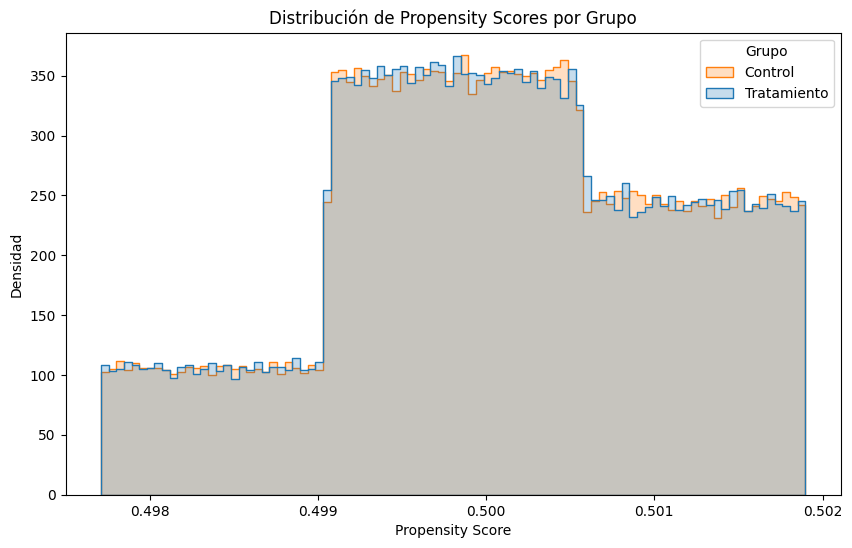

In [9]:
# Visualizar los propensity scores

plt.figure(figsize=(10, 6))
sns.histplot(data=subdata, x='propensity_score', hue='group_treatment', element='step', stat='density', common_norm=False)
plt.title('Distribución de Propensity Scores por Grupo')
plt.xlabel('Propensity Score')
plt.ylabel('Densidad')
plt.legend(title='Grupo', labels=['Control', 'Tratamiento'])
plt.show()

4. Contruye el histograma de Y* y señale la media en el plot. Revise tutorial.

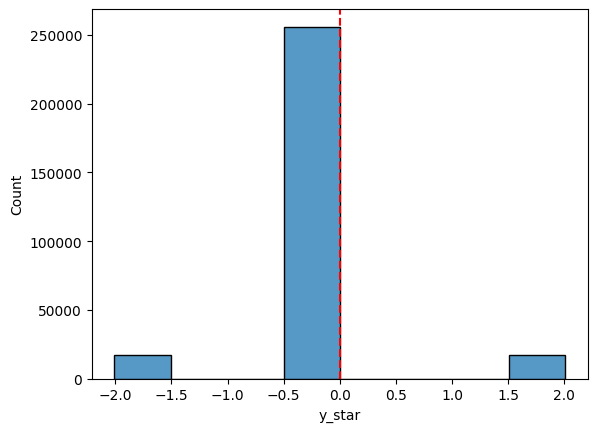

In [11]:
subdata['y_star'] = subdata['converted'] / (subdata['landing_page_new_page'] * subdata['propensity_score'] - (1-subdata['landing_page_new_page']) * (1-subdata['propensity_score']))

sns.histplot(data=subdata, x='y_star', binwidth= 0.5)
plt.axvline(x=subdata['y_star'].mean(), color='red', linestyle='--')

5. Muestre el plot del tree generado para el modelo usando como covariables la variable pais y el timestamp.

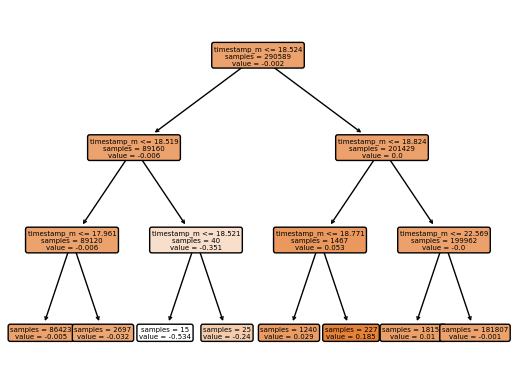

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

tree = DecisionTreeRegressor(max_depth=3).fit(X, subdata['y_star'])
subdata['y_hat'] = tree.predict(X)

feature_names = X.columns.tolist()
plot_tree(tree, filled=True, fontsize=5, feature_names=feature_names, impurity=False, rounded=True)
plt.show()

6. Repita 5 pero con la libreria econml utilizando SingleTreeCateInterpreter.

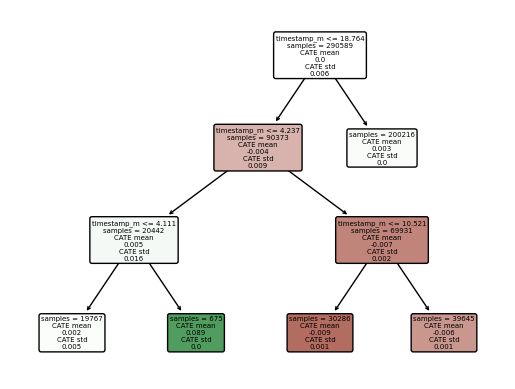

In [15]:
from econml.dml import CausalForestDML

np.random.seed(2024)

tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=3)
tree_model = tree_model.fit(Y=subdata['converted'], X=X, T=subdata['group_treatment'])

from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=3).interpret(tree_model, X)
intrp.plot(feature_names=feature_names, fontsize=5)

7. Interprete resultados y compare la imagen en 6 con la imagen en 5. Utilice los terminos tecnicos y revise la literatura para explicar a detalle que esta haciendo este causal tree y cual es la diferencia con decision trees.

Con el árbol de regresión el objetivo es predecir los valores de Y* y solo se calculan el efecto promedio del tratamiento. En ese sentido, se tiene que el promedio de Y* es -0.002. Se observa que Y* alcanza un valor promedio de 0.185 cuando el tiempo es mayor a 18.77 minutos y menor a 22.57 minutos. Asimismo, Y* tiene un valor promedio de -0.5 cuando el tiempo se encuentra entre 17.96 y 18.52 minutos.

De otro lado, el causal forest muestra los efectos heteronégeos entre el grupo . Destaca que para tiempos posteriores a 18.76 minutos no se encuentra efectos heterogéneos. Sin embargo, para las personas que se quedaron menor tiempo al indicado sí se observan efectos heterogéneos, siendo el mayor efecto de 0.089 para tiempos mayores a 4.11 minutos.
